In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

# Silence warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

---

## Finding duplicate queries

How many users make duplicate queries during a day?

In [2]:
import random

# number of unique queries
X = 1000
# number of duplicate queries
D = 500
# in total a user will have made X + 2*D queries

queries = ['x%i' % i for i in range(X)] + ['d%i' % (i%D) for i in range(2*D)]
print(D/len(queries))
#queries

0.25


In [3]:
# let's just sub-sample the queries
sample = [query for query in queries if random.random() < 0.1]
#sample

In [4]:
from collections import Counter

def duplicates(queries):
    counts = Counter(queries)
    dupes = []
    for query,count in counts.items():
        if count > 1:
            dupes.append(query)
    return len(dupes)

duplicates(sample) / len(sample)
# ... something isn't quite right with this

0.015384615384615385

In [5]:
# sample users, not queries
# pick a fraction (say one tenth) of users and collect all their queries
import string

X = 1000
D = 500
U = 50

queries = []

for u in range(U):
    # our users need a name!
    name = ''.join([random.choice(string.ascii_letters) for _ in range(10)])
    queries.extend([(name, 'x%i' % i) for i in range(X)] +
                   [(name, 'd%i' % (i%D)) for i in range(2*D)])

random.shuffle(queries)
queries[:30] # 30 random (user, query) pairs

[('PKtfIlXpFc', 'x443'),
 ('NbDlXQddlN', 'x156'),
 ('fdJNthMvGL', 'd366'),
 ('vCegMXTyle', 'x791'),
 ('CxbItMdWay', 'd440'),
 ('PjtAvBGZFU', 'x668'),
 ('MBxrJZHhUm', 'd462'),
 ('KVmfFnliSy', 'x78'),
 ('zkMaOnSKNj', 'd278'),
 ('tRWDKjJZMf', 'd397'),
 ('BsXkmnWKTn', 'x741'),
 ('NdldfFppdc', 'd452'),
 ('MBxrJZHhUm', 'd195'),
 ('BZdZbUWEaJ', 'd59'),
 ('BsXkmnWKTn', 'x171'),
 ('fdJNthMvGL', 'd131'),
 ('IUDrLeHBDU', 'd74'),
 ('yjiBwegmPq', 'd265'),
 ('iTLKFoxPTI', 'x623'),
 ('IxjbvxKDxs', 'd374'),
 ('MBxrJZHhUm', 'x469'),
 ('lhRZUSrAJA', 'x662'),
 ('dSrEvdUNCV', 'x943'),
 ('PTLRakBqLh', 'x311'),
 ('PwMKtfjLBI', 'x336'),
 ('bWKqAtoXQO', 'd297'),
 ('bWKqAtoXQO', 'd126'),
 ('vCegMXTyle', 'd422'),
 ('PjtAvBGZFU', 'x17'),
 ('iqeBSpnMtg', 'd354')]

---

## Hash functions

We need a way to map from a username to some kind of numerical ID.
How do we do this? Especially if we don't know how many users there are? Need a function
that maps arbitrary inputs to a defined range of integers.

In [6]:
from sklearn.utils import murmurhash3_32

# python's builtin hash function isn't even approximately random
def hash_(n, seed=1):
    return murmurhash3_32(n, seed=seed, positive=True)

print(hash_("tim"), hash_("jim"), hash_("fred"), hash_("joe"))

2095282958 2892697151 374763764 1284432482


`hash_(item)` produces a 'random' number between `0` and `2**32-1`.
The output is uniformly distributed between the two limits and the same input will always produce the same output. Designing hash functions could be the topic of a whole lecture ... let's just assume they work and are a piece of magic handed down to us.

We use it as a tool to convert arbitrary objects/values into uniformly distributed 'random' values.

In [7]:
# hash name into ten buckets, pick all users that fall into bucket 1

sample = []
for (user, query) in queries:
    if (hash_(user) % 10) == 0:
        sample.append((user,query))
    
duplicates(sample) / len(sample)

0.25

In [8]:
# the bucket will contain approximately five users
set([x[0] for x in sample])

{'FWWkodRDgM', 'vCegMXTyle', 'zgOGInpEEj'}

---

## Approximate answers

Often approximate answers are plenty good enough. Especially if you can compute a bound on the size of the mistake. And even more so if the alternative is getting no answer because your data is infinite!

Approximate is different from random subsampling:

In [9]:
x = [random.randint(0, 2e9) for _ in range(5000)]

y = [i>>8 for i in x]

In [10]:
# remove the last 8bits from the integers
bin(x[0])

'0b100011010100110011110010011000'

In [11]:
bin(x[0]>>8), bin(x[0])[:-8]

('0b1000110101001100111100', '0b1000110101001100111100')

In [12]:
(x[0], x[0]>>8)

(592657560, 2315068)

In [13]:
mean_x = sum(x) / len(x)
mean_y = sum(y) / len(y) * 2**8

# compare the two answers and the fractional difference between the two
print(mean_x, mean_y, 100*(mean_x-mean_y)/mean_x)

1014148516.8648 1014148389.2736 1.2581115869353177e-05


---

## Bloom filter

Have I seen this item before? Is this a word? Is there a value for this key in our database? Is this email address in the users addressbook?

In [14]:
from sklearn.utils import check_random_state
from ipythonblocks import BlockGrid

class BloomFilter:
    def __init__(self, n, k, random_state=None):
        # k hash functions and n bits
        self.n = n
        self.bits = np.zeros(n, dtype=bool)
        
        # our k hash functions
        self.rng = check_random_state(random_state)
        r = self.rng.randint(1e9)
        self.k = [r + k for k in range(1, k+1)]

    def add(self, val):
        for i in self.k:
            idx = hash_(val, i) % self.n
            self.bits[idx] = True

    def __contains__(self, val):
        for i in self.k:
            if not self.bits[hash_(val, i) % self.n]:
                return False
            
        return True
    
    def show(self):
        grid = BlockGrid(self.n, 1, fill=(0,0,0))
        for n,v in enumerate(self.bits):
            if v:
                grid[0, n] = (255,0,0)
        return grid.show()

In [15]:
# my laptop doesn't have that much memory :( so use 1e4 instead of 1e9
B = int(8e1)
S = int(1e1)

b = BloomFilter(B, 1)
b.show()

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [16]:
for _ in range(S):
    r = np.random.randint(2**31 - 1)
    b.add(r)
    
b.show()

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [17]:
# with more hash functions
b = BloomFilter(B, 4)
for _ in range(S):
    r = np.random.randint(2**31 - 1)
    b.add(r)
    
b.show()

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


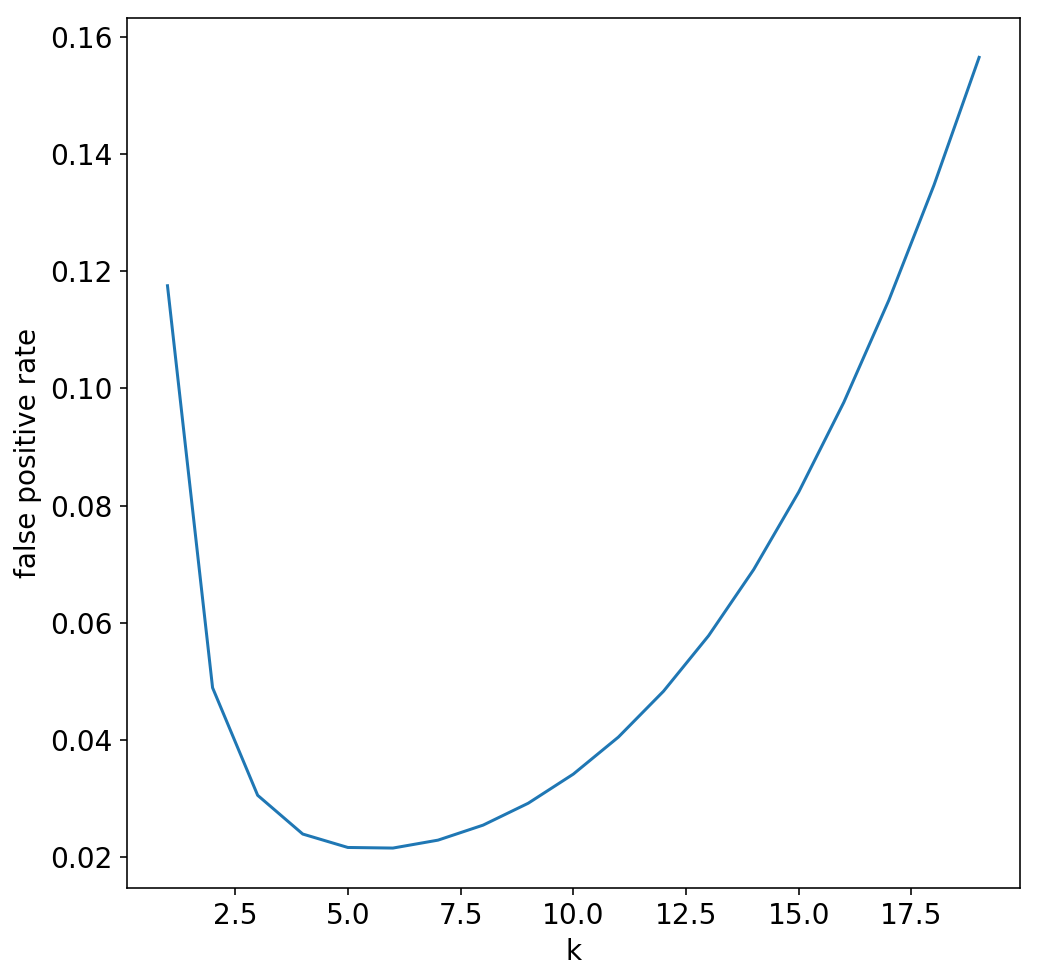

In [18]:
# optimal k?
k = np.array(range(1, 20))
plt.plot(k, (1-np.exp(-(k*S)/B))**k)
plt.xlabel("k")
plt.ylabel("false positive rate");

---

## Coin flips

You can estimate the number of times someone flipped a coin by keeping track of the longest run of "heads":

In [19]:
def generate_coinflips(num):
    return [random.choice([0, 1]) for i in range(num)]

def longest_run_zero(x):
    i = 0
    count = 0
    max_count = 0
    while i < len(x):
        if x[i] == 0:
            count += 1
        else:
            if count > max_count:
                max_count = count
            count = 0
        i += 1
        
    return max_count


def longest_run_mc(flips, repeats):
    z = []
    for i in range(repeats):
        x = generate_coinflips(flips)
        count = longest_run_zero(x)
        z.append(count)
        
    return z

6.643856189774725


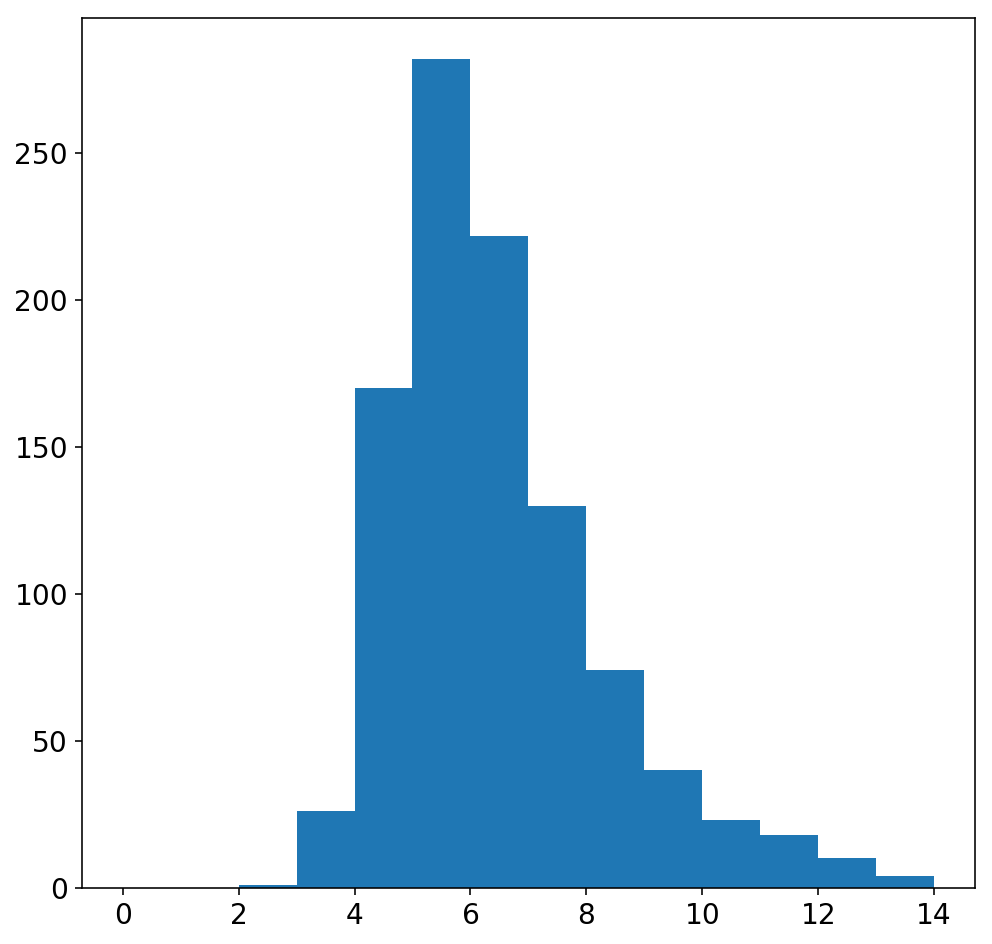

In [20]:
import math

d = longest_run_mc(100, 1000)
plt.hist(d, bins=max(d), range=(0, max(d)))

# we expect a peak right around...
print(math.log(100, 2))

8.965784284662087


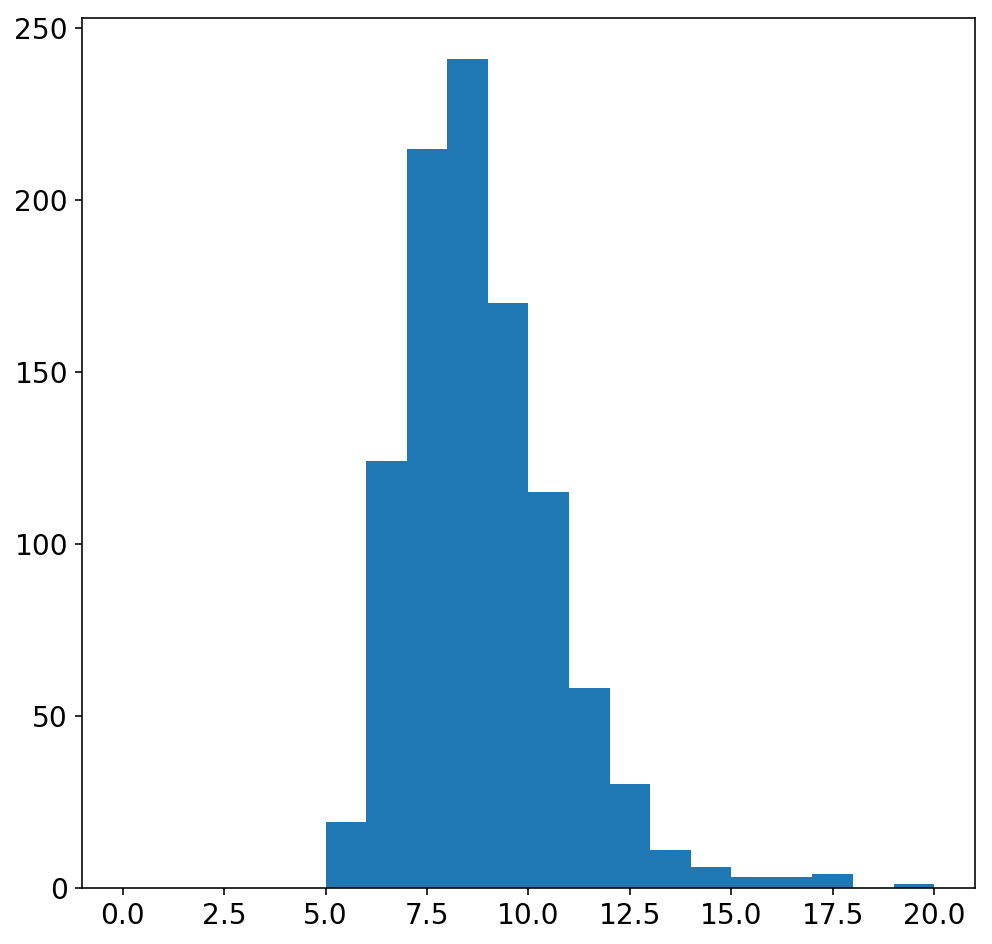

In [21]:
# flip 500 times in a row
d = longest_run_mc(500, 1000)
plt.hist(d, bins=max(d), range=(0, max(d)))

print(math.log(500, 2))